In [1]:
pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.1/871.1 kB 15.0 MB/s eta 0:00:00


In [2]:
import cv2
import numpy as np
import torch
import ultralytics
from PIL import Image, ImageDraw
from IPython.display import display
from google.colab.patches import cv2_imshow

In [3]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

/usr/local/lib/python3.10/dist-packages/torch/hub.py:295: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


requirements: Ultralytics requirements ['gitpython>=3.1.30', 'pillow>=10.3.0'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 133.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 208.3 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0

requirements: AutoUpdate success ✅ 4.9s, installed 2 packages: ['gitpython>=3.1.30', 'pillow>=10.3.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



YOLOv5 🚀 2024-8-27 Python-3.10.12 torch-2.4.0+cu121 CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 250MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [4]:
def get_heatmap(detections, image_shape):
    heatmap = np.zeros(image_shape[:2], dtype=np.float32)

    for det in detections:
        x1, y1, x2, y2 = map(int, det[:4])
        confidence = det[4]
        heatmap[y1:y2, x1:x2] += confidence

    heatmap /= np.max(heatmap)
    return heatmap

In [62]:
def crop_image_with_aspect_ratio(image, aspect_ratio, model):
    results = model(image)
    detections = results.xyxy[0].numpy()

    height, width, _ = image.shape

    # Calculate crop dimensions based on aspect ratio
    crop_width = int(min(width, height * aspect_ratio))
    crop_height = int(min(height, width / aspect_ratio))

    # Initialize crop coordinates
    x1, y1, x2, y2 = 0, 0, width, height

    if len(detections) > 0:
        # Use the first detected object to define the crop area
        x1, y1, x2, y2 = detections[0][:4].astype(int)

        # Ensure coordinates are within image bounds
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(width, x2)
        y2 = min(height, y2)

        # Calculate the center of the detection
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2

        # Adjust crop coordinates based on aspect ratio
        crop_x1 = max(0, center_x - crop_width // 2)
        crop_y1 = max(0, center_y - crop_height // 2)
        crop_x2 = min(width, crop_x1 + crop_width)
        crop_y2 = min(height, crop_y1 + crop_height)

        # Update x1, y1, x2, y2 to the adjusted crop coordinates
        x1, y1, x2, y2 = crop_x1, crop_y1, crop_x2, crop_y2
    else:
        # No significant detections, use image center
        center_x = width // 2
        center_y = height // 2

        # Calculate crop coordinates based on image center
        crop_x1 = max(0, center_x - crop_width // 2)
        crop_y1 = max(0, center_y - crop_height // 2)
        crop_x2 = min(width, crop_x1 + crop_width)
        crop_y2 = min(height, crop_y1 + crop_height)

        # Update x1, y1, x2, y2 to the adjusted crop coordinates
        x1, y1, x2, y2 = crop_x1, crop_y1, crop_x2, crop_y2

    # Convert OpenCV image (BGR) to PIL image (RGB)
    pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Draw rectangle on the image
    draw = ImageDraw.Draw(pil_image)
    draw.rectangle([x1, y1, x2, y2], outline="green", width=3)

    # Display the image with rectangle
    display(pil_image)

    # Crop and resize the image
    cropped_image = image[y1:y2, x1:x2]
    final_image = cv2.resize(cropped_image, (crop_width, crop_height))

    return final_image

In [68]:
image = cv2.imread(r"/content/mothers-love.jpg")

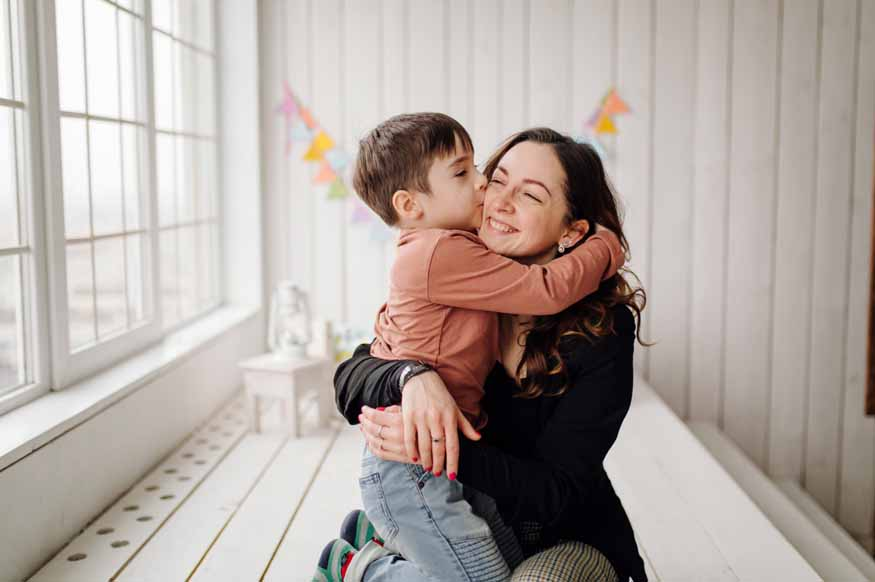

In [69]:
cv2_imshow(image)

In [70]:
aspect_ratio=2/3

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


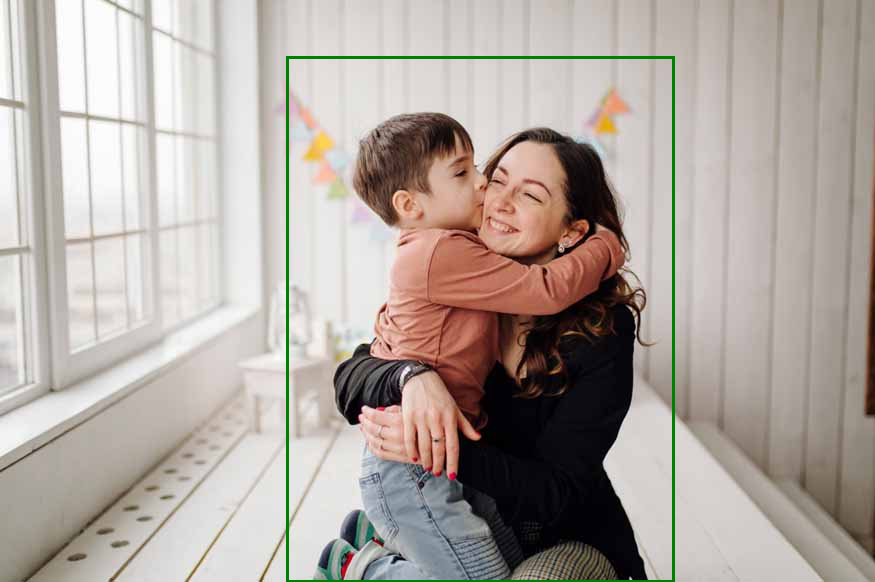

In [71]:
cropped_image = crop_image_with_aspect_ratio(image, aspect_ratio, model)

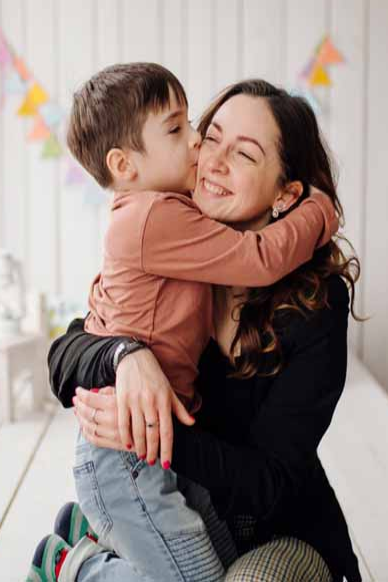

In [72]:
cv2.imwrite("cropped_image.jpg", cropped_image)
cv2_imshow(cropped_image)